In [7]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV

from sklearn import metrics

from sklearn.metrics import confusion_matrix

In [8]:
class FeatureExtractor(StandardScaler):
    """Extracts several potentially important features from an Amazon username:
        - is_fullname
        - vowels_in_profilename
        - profile_length
        - profile_cap (is the profile capitalized?)
        - num_caps
        """
    def __init__(self):
        return None
    
    def fit(self, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['has_quotes'] = X_copy['ProfileName'].str.contains('"').map(lambda x: 1 if x else 0)
        
        def full_name_check(text):
            pattern = r"\b[A-Z][a-z]+ [A-Z]. [A-Z][a-z]+"
            if re.match(pattern=pattern, string=str(text)) != None:
                return 1
            else:
                return 0
        X_copy['is_fullname'] = X_copy['ProfileName'].map(full_name_check)
        
        def vowel_counter(text):
            vowels = {'a', 'e', 'i', 'o', 'u'}
            count = 0
            for letter in str(text):
                if letter.lower() in vowels:
                    count += 1
            return count
        X_copy['vowels_in_profilename'] = X_copy['ProfileName'].map(vowel_counter)
        
        X_copy['profile_length'] = X_copy['ProfileName'].map(lambda x: len(str(x)))
        
        X_copy['profile_cap'] = X_copy['ProfileName'].map(lambda x: 1 if str(x)[0].isupper() else 0)
        def uppering(char):
            return 1 if char.isupper() else 0

        def upper_counter(s):
            return sum([uppering(x) for x in str(s)])

        X_copy['num_caps'] = X_copy['ProfileName'].map(upper_counter)
        X_copy.drop(['ProfileName'], axis = 1, inplace = True)
        X_copy = X_copy.values
        return X_copy
        
    def fit_transform(self, X, y=None):
        self.fit()
        return self.transform(X)


In [13]:
def fit_and_make_report(model, show_best = False):
    model.fit(X_train, y_train)
    if show_best:
        print(model.best_estimator_)
    cvs = cross_val_score(model, X_train, y_train, cv = 10)
    print("Mean cross-val score: {:.2%}".format(cvs.mean()))
    print("Cross-val score standard deviation: {:.2%}".format(cvs.std()))
    print("Model Score on test data: {:.2%}".format(model.score(X_test, y_test)))
    print("--")
    print("Area under ROC curve Score on test data: {:.2%}".format(metrics.roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test)])))
    sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot = True, fmt = 'g')
    plt.show()

In [14]:
df = pd.read_csv('./data/Reviews.csv')
df = df[df['ProfileName'].notna()]

df['helpfulness'] = df['HelpfulnessNumerator'].map(lambda x: 1 if x > 0 else 0)

X_train, X_test, y_train, y_test = train_test_split(df[['ProfileName']], df['helpfulness'])

In [15]:
feature_extraction = FeatureExtractor()
xtra = ExtraTreesClassifier(n_estimators=16, max_depth=4)

steps = [('feature_extraction', feature_extraction), ('xtra', xtra)]

extract_and_xtra = Pipeline(steps)

Mean cross-val score: 53.75%
Cross-val score standard deviation: 0.19%
Model Score on test data: 53.62%
--
Area under ROC curve Score on test data: 53.40%


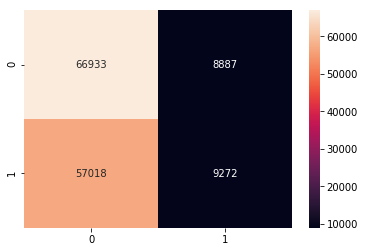

In [16]:
fit_and_make_report(extract_and_xtra)

In [19]:
print(metrics.classification_report(y_test, extract_and_xtra.predict(X_test)))

             precision    recall  f1-score   support

          0       0.54      0.88      0.67     75820
          1       0.51      0.14      0.22     66290

avg / total       0.53      0.54      0.46    142110



In [17]:
feature_extraction = FeatureExtractor()
rf = RandomForestClassifier()
steps = [('feature_extraction', feature_extraction), ('rf', rf)]

extract_and_rf = Pipeline(steps)

params = {
    "rf__n_estimators": [10,15,20],
    "rf__max_depth": [None, 4]
}
gridsearch = GridSearchCV(extract_and_rf, param_grid=params)

Pipeline(memory=None,
     steps=[('feature_extraction', FeatureExtractor()), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Mean cross-val score: 55.43%
Cross-val score standard deviation: 0.14%
Model Score on test data: 55.47%
--
Area under ROC curve Score on test data: 56.48%


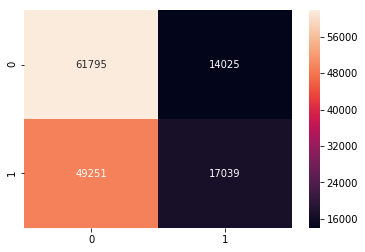

In [18]:
fit_and_make_report(gridsearch, show_best = True)

In [20]:
print(metrics.classification_report(y_test, gridsearch.predict(X_test)))

             precision    recall  f1-score   support

          0       0.56      0.82      0.66     75820
          1       0.55      0.26      0.35     66290

avg / total       0.55      0.55      0.52    142110



In [31]:
gridsearch.estimator.get_params()['steps'][1][1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)